**1. Preprocessing**

In [1]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Define the text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove user handles
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

# Load and preprocess the dataset
def load_and_preprocess(file_path):
    processed_data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split(';')
            if len(parts) == 2:
                text, label = parts
                processed_text = preprocess_text(text)
                processed_data.append((processed_text, label))
    return processed_data

# Example of processing the train and test datasets
train_data = load_and_preprocess('/content/train.txt')
test_data = load_and_preprocess('/content/test.txt')

# Example of how to access processed text and labels
for text, label in train_data[:5]:
    print("Processed Text:", text)
    print("Label:", label)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Processed Text: didnt feel humili
Label: sadness
Processed Text: go feel hopeless damn hope around someon care awak
Label: sadness
Processed Text: im grab minut post feel greedi wrong
Label: anger
Processed Text: ever feel nostalg fireplac know still properti
Label: love
Processed Text: feel grouchi
Label: anger


**2. Transform Data with TF-IDF Vectorizer**

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Separate the processed text and labels
texts_train = [text for text, label in train_data]
labels_train = [label for text, label in train_data]
texts_test = [text for text, label in test_data]
labels_test = [label for text, label in test_data]

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(texts_train).toarray()
X_test = vectorizer.transform(texts_test).toarray()

# Encode the labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(labels_train)
y_test = label_encoder.transform(labels_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Output for checking
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train sample:", y_train[:5])
print("y_test sample:", y_test[:5])

X_train shape: (16000, 1000)
X_test shape: (2000, 1000)
y_train sample: [[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]
y_test sample: [[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]


**3 .Fully Connected Neural Network**

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Building the model
fc_model = Sequential([
    Dense(512, activation='relu', input_dim=1000),  # Input dimension matches the number of features in X_train
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')  # Output layer nodes equal to the number of classes
])

# Compile the model
fc_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history_fc = fc_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
500/500 [==============================] - 10s 15ms/step - loss: 0.9683 - accuracy: 0.6489 - val_loss: 0.4856 - val_accuracy: 0.8275
Epoch 2/10
500/500 [==============================] - 6s 13ms/step - loss: 0.4383 - accuracy: 0.8538 - val_loss: 0.4384 - val_accuracy: 0.8320
Epoch 3/10
500/500 [==============================] - 5s 10ms/step - loss: 0.3310 - accuracy: 0.8834 - val_loss: 0.4441 - val_accuracy: 0.8285
Epoch 4/10
500/500 [==============================] - 5s 10ms/step - loss: 0.2681 - accuracy: 0.9062 - val_loss: 0.4675 - val_accuracy: 0.8355
Epoch 5/10
500/500 [==============================] - 7s 14ms/step - loss: 0.2079 - accuracy: 0.9263 - val_loss: 0.5079 - val_accuracy: 0.8280
Epoch 6/10
500/500 [==============================] - 5s 11ms/step - loss: 0.1625 - accuracy: 0.9444 - val_loss: 0.5298 - val_accuracy: 0.8295
Epoch 7/10
500/500 [==============================] - 7s 13ms/step - loss: 0.1294 - accuracy: 0.9556 - val_loss: 0.5683 - val_accuracy: 0.822

In [6]:
# Evaluate the model on the test set
fc_eval = fc_model.evaluate(X_test, y_test)
print(f"Test Loss: {fc_eval[0]}, Test Accuracy: {fc_eval[1]}")

63/63 [==============================] - 0s 6ms/step - loss: 0.6773 - accuracy: 0.8240
Test Loss: 0.6773126721382141, Test Accuracy: 0.8240000009536743


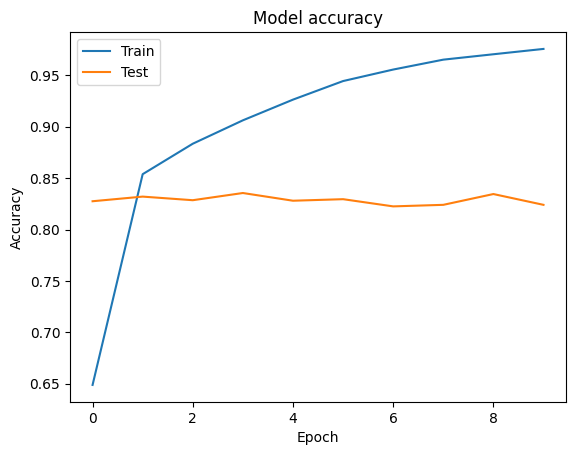

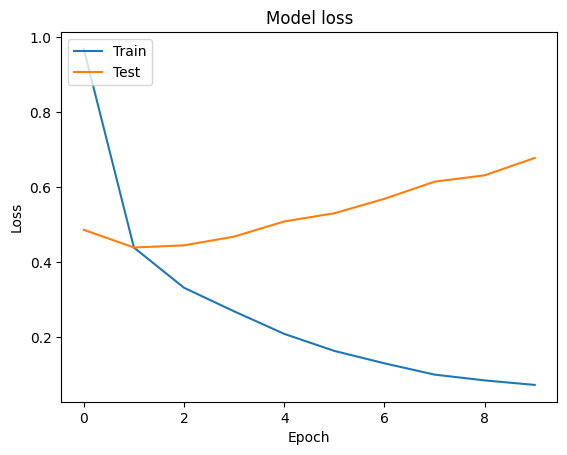

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_fc.history['accuracy'])
plt.plot(history_fc.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_fc.history['loss'])
plt.plot(history_fc.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

The training accuracy graph shows a significant gap from the testing accuracy, suggesting overfitting; meanwhile, the training loss decreases significantly more than the testing loss, further confirming that the model may be too tailored to the training data without generalizing well to new, unseen data.

adding L2 regularization, increasing dropout, and implementing early stopping to help combat the overfitting observed in the model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Building the model with regularization and increased dropout
fc_model = Sequential([
    Dense(512, activation='relu', input_dim=1000, kernel_regularizer=l2(0.01)),
    Dropout(0.6),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.6),
    Dense(y_train.shape[1], activation='softmax')
])

# Compile the model
fc_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Setup Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

# Training the model with Early Stopping
history_fc = fc_model.fit(X_train, y_train, epochs=10, batch_size=32,
                          validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/10
500/500 [==============================] - 11s 19ms/step - loss: 2.0759 - accuracy: 0.3479 - val_loss: 1.5925 - val_accuracy: 0.3660
Epoch 2/10
500/500 [==============================] - 6s 12ms/step - loss: 1.6278 - accuracy: 0.4975 - val_loss: 1.5347 - val_accuracy: 0.5795
Epoch 3/10
500/500 [==============================] - 8s 17ms/step - loss: 1.5581 - accuracy: 0.5569 - val_loss: 1.4567 - val_accuracy: 0.5900
Epoch 4/10
500/500 [==============================] - 8s 16ms/step - loss: 1.4889 - accuracy: 0.5799 - val_loss: 1.3886 - val_accuracy: 0.6115
Epoch 5/10
500/500 [==============================] - 9s 17ms/step - loss: 1.4372 - accuracy: 0.6194 - val_loss: 1.3386 - val_accuracy: 0.7045
Epoch 6/10
500/500 [==============================] - 7s 13ms/step - loss: 1.3967 - accuracy: 0.6445 - val_loss: 1.2981 - val_accuracy: 0.7180
Epoch 7/10
500/500 [==============================] - 7s 14ms/step - loss: 1.3659 - accuracy: 0.6553 - val_loss: 1.2968 - val_accuracy: 0.726

63/63 [==============================] - 0s 7ms/step - loss: 1.2052 - accuracy: 0.7275
Test Loss: 1.2052150964736938
Test Accuracy: 0.7275000214576721


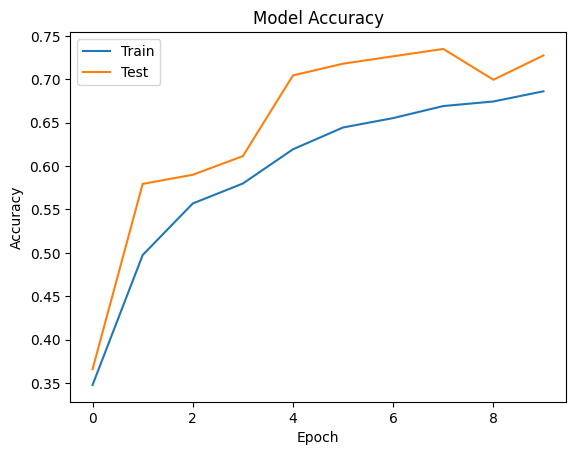

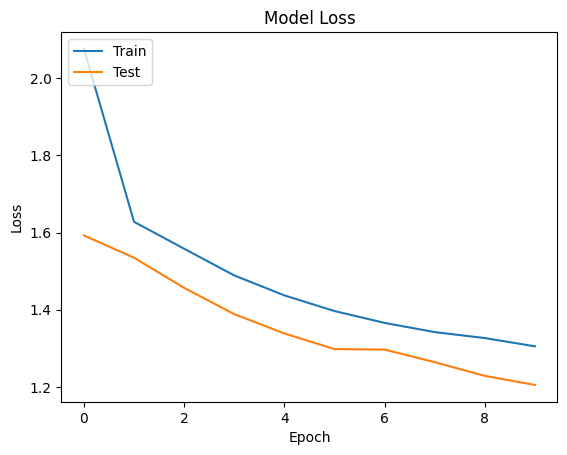

In [9]:
# Evaluate the model on the test set
evaluation = fc_model.evaluate(X_test, y_test)

# Print the test loss and accuracy
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")

# Plot training & validation accuracy values
import matplotlib.pyplot as plt

plt.plot(history_fc.history['accuracy'])
plt.plot(history_fc.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_fc.history['loss'])
plt.plot(history_fc.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**4. LSTM**

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Assuming max_length (maximum sequence length) based on your data
max_length = 100

# Building the LSTM model
lstm_model = Sequential([
    Embedding(input_dim=1000, output_dim=64, input_length=max_length),  # 1000 should be vocabulary size
    LSTM(128, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Prepare the data (ensure input sequences are padded/truncated to max_length)
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train_padded = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')

# Train the model
history_lstm = lstm_model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_data=(X_test_padded, y_test))

Epoch 1/10
500/500 [==============================] - 81s 154ms/step - loss: 1.5852 - accuracy: 0.3244 - val_loss: 1.5641 - val_accuracy: 0.3475
Epoch 2/10
500/500 [==============================] - 76s 151ms/step - loss: 1.5784 - accuracy: 0.3313 - val_loss: 1.5648 - val_accuracy: 0.3475
Epoch 3/10
500/500 [==============================] - 80s 160ms/step - loss: 1.5778 - accuracy: 0.3310 - val_loss: 1.5616 - val_accuracy: 0.3475
Epoch 4/10
500/500 [==============================] - 77s 154ms/step - loss: 1.5772 - accuracy: 0.3343 - val_loss: 1.5608 - val_accuracy: 0.3475
Epoch 5/10
500/500 [==============================] - 75s 151ms/step - loss: 1.5778 - accuracy: 0.3340 - val_loss: 1.5587 - val_accuracy: 0.3475
Epoch 6/10
500/500 [==============================] - 74s 148ms/step - loss: 1.5774 - accuracy: 0.3309 - val_loss: 1.5637 - val_accuracy: 0.3475
Epoch 7/10
500/500 [==============================] - 74s 148ms/step - loss: 1.5762 - accuracy: 0.3329 - val_loss: 1.5602 - val_ac

63/63 [==============================] - 5s 86ms/step - loss: 1.5605 - accuracy: 0.3475
Test Loss: 1.5605041980743408, Test Accuracy: 0.3474999964237213


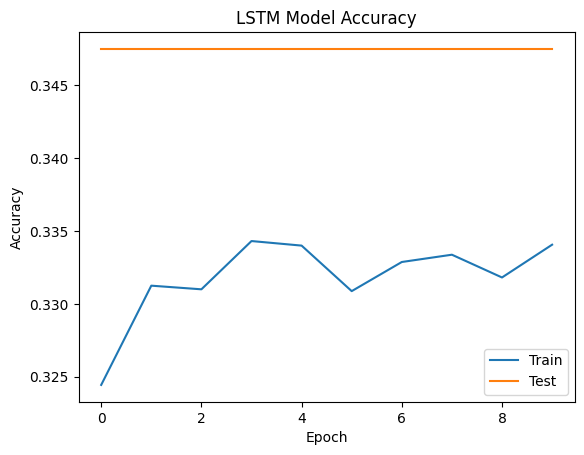

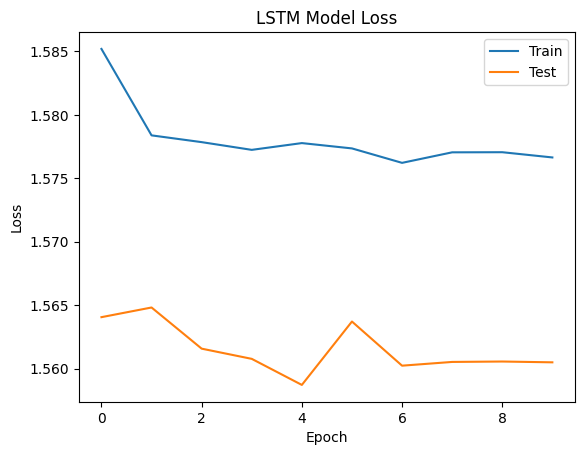

In [11]:
# Evaluate the model on the test set
lstm_eval = lstm_model.evaluate(X_test_padded, y_test)
print(f"Test Loss: {lstm_eval[0]}, Test Accuracy: {lstm_eval[1]}")

# Plotting training & validation accuracy
import matplotlib.pyplot as plt
plt.plot(history_lstm.history['accuracy'], label='Train')
plt.plot(history_lstm.history['val_accuracy'], label='Test')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training & validation loss
plt.plot(history_lstm.history['loss'], label='Train')
plt.plot(history_lstm.history['val_loss'], label='Test')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**5.  Fine-tuned Transformer Model**

In [29]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy


# Load the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(train_labels)))

# Setup the optimizer and compile the model correctly
optimizer = Adam(learning_rate=5e-5)
loss = SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Proceed with training
history = model.fit(train_dataset, epochs=3, validation_data=test_dataset)
# Define a function to load data from a file and preprocess
def load_data(file_path):
    texts, labels = [], []
    label_map = {'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split(';')
            if len(parts) == 2:
                text, label = parts
                texts.append(text)
                labels.append(label_map[label])
    return texts, labels

# Load and preprocess the dataset
train_texts, train_labels = load_data('/content/train.txt')
test_texts, test_labels = load_data('/content/test.txt')

# Tokenize the data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Convert to TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).shuffle(1000).batch(16)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels)).batch(16)

# Load the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(train_labels)))

# Compile and train the model
optimizer = Adam(learning_rate=5e-5)
loss = SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(train_dataset, epochs=3, validation_data=test_dataset)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: Could not interpret optimizer identifier: <keras.src.optimizers.adam.Adam object at 0x780578e0b3d0>

I met some problem with fine-tuned transformer model and couldn't fix it)

**6. Comparing to the validation dataset**

In [32]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Preprocess function and data loading
def preprocess_text(text):
    import re
    import nltk
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    from nltk.stem import PorterStemmer

    nltk.download('punkt')
    nltk.download('stopwords')

    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

def load_and_preprocess(file_path):
    processed_data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split(';')
            if len(parts) == 2:
                text, label = parts
                processed_text = preprocess_text(text)
                processed_data.append((processed_text, label))
    return processed_data

# Load the validation data
validation_data = load_and_preprocess('/content/validation.txt')

# Separating text and labels
texts_validation = [text for text, label in validation_data]
labels_validation = [label for text, label in validation_data]

# Vectorizing texts
vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(texts_train).toarray()
X_test = vectorizer.transform(texts_test).toarray()
X_validation = vectorizer.transform(texts_validation).toarray()

# Encoding labels
label_encoder = LabelEncoder()
y_train = to_categorical(label_encoder.fit_transform(labels_train))
y_test = to_categorical(label_encoder.transform(labels_test))
y_validation = to_categorical(label_encoder.transform(labels_validation))

# Define your model (assuming a previously defined 'model' variable)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model (assuming the model and training dataset is ready)
history = fc_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_validation, y_validation))

# Evaluate the model
test_eval = model.evaluate(X_test, y_test)
print("Test Loss:", test_eval[0], "Test Accuracy:", test_eval[1])

流式输出内容被截断，只能显示最后 5000 行内容。
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_d

Epoch 1/10
500/500 [==============================] - 6s 12ms/step - loss: 1.2988 - accuracy: 0.6912 - val_loss: 1.2328 - val_accuracy: 0.7010
Epoch 2/10
500/500 [==============================] - 7s 15ms/step - loss: 1.2844 - accuracy: 0.6974 - val_loss: 1.2097 - val_accuracy: 0.7365
Epoch 3/10
500/500 [==============================] - 6s 12ms/step - loss: 1.2701 - accuracy: 0.7039 - val_loss: 1.1919 - val_accuracy: 0.7330
Epoch 4/10
500/500 [==============================] - 8s 16ms/step - loss: 1.2634 - accuracy: 0.7112 - val_loss: 1.2167 - val_accuracy: 0.7320
Epoch 5/10
500/500 [==============================] - 6s 12ms/step - loss: 1.2587 - accuracy: 0.7144 - val_loss: 1.1975 - val_accuracy: 0.7295
Epoch 6/10
500/500 [==============================] - 8s 15ms/step - loss: 1.2459 - accuracy: 0.7196 - val_loss: 1.1670 - val_accuracy: 0.7400
Epoch 7/10
500/500 [==============================] - 8s 15ms/step - loss: 1.2416 - accuracy: 0.7186 - val_loss: 1.1781 - val_accuracy: 0.7375

TypeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 2063, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 2034, in run_step  *
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_utils.py", line 1779, in test_step  *
        y_pred = self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 558, in error_handler  *
        return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 588, in __call__  *
        return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 558, in error_handler  *
        return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__  *
        outputs = call_fn(inputs, *args, **kwargs)
    File "/tmp/__autograph_generated_filey2gy5jnx.py", line 162, in error_handler
        raise ag__.converted_call(ag__.ld(new_e).with_traceback, (ag__.ld(e).__traceback__,), None, fscope_1) from None
    File "/tmp/__autograph_generated_filey2gy5jnx.py", line 34, in error_handler
        retval__1 = ag__.converted_call(ag__.ld(fn), tuple(ag__.ld(args)), dict(**ag__.ld(kwargs)), fscope_1)
    File "/tmp/__autograph_generated_file7i7covg_.py", line 46, in tf__call
        ag__.if_stmt(ag__.ld(input_ids) is not None, if_body_1, else_body_1, get_state_1, set_state_1, ('inputs_embeds',), 1)
    File "/tmp/__autograph_generated_file7i7covg_.py", line 41, in if_body_1
        inputs_embeds = ag__.converted_call(ag__.ld(tf).gather, (), dict(params=ag__.ld(self).weight, indices=ag__.ld(input_ids)), fscope)

    TypeError: Exception encountered when calling layer 'tf_bert_for_sequence_classification_13' (type TFBertForSequenceClassification).
    
    in user code:
    
        File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_utils.py", line 1734, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "/usr/local/lib/python3.10/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 1746, in call  *
            outputs = self.bert(
        File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 558, in error_handler  *
            return fn(*args, **kwargs)
        File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__  *
            outputs = call_fn(inputs, *args, **kwargs)
        File "/tmp/__autograph_generated_filey2gy5jnx.py", line 162, in error_handler
            raise ag__.converted_call(ag__.ld(new_e).with_traceback, (ag__.ld(e).__traceback__,), None, fscope_1) from None
        File "/tmp/__autograph_generated_filey2gy5jnx.py", line 34, in error_handler
            retval__1 = ag__.converted_call(ag__.ld(fn), tuple(ag__.ld(args)), dict(**ag__.ld(kwargs)), fscope_1)
        File "/tmp/__autograph_generated_file7i7covg_.py", line 46, in tf__call
            ag__.if_stmt(ag__.ld(input_ids) is not None, if_body_1, else_body_1, get_state_1, set_state_1, ('inputs_embeds',), 1)
        File "/tmp/__autograph_generated_file7i7covg_.py", line 41, in if_body_1
            inputs_embeds = ag__.converted_call(ag__.ld(tf).gather, (), dict(params=ag__.ld(self).weight, indices=ag__.ld(input_ids)), fscope)
    
        TypeError: Exception encountered when calling layer 'bert' (type TFBertMainLayer).
        
        in user code:
        
            File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_utils.py", line 1734, in run_call_with_unpacked_inputs  *
                return func(self, **unpacked_inputs)
            File "/usr/local/lib/python3.10/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 887, in call  *
                embedding_output = self.embeddings(
            File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 558, in error_handler  *
                return fn(*args, **kwargs)
            File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__  *
                outputs = call_fn(inputs, *args, **kwargs)
            File "/tmp/__autograph_generated_filey2gy5jnx.py", line 162, in error_handler  **
                raise ag__.converted_call(ag__.ld(new_e).with_traceback, (ag__.ld(e).__traceback__,), None, fscope_1) from None
            File "/tmp/__autograph_generated_filey2gy5jnx.py", line 34, in error_handler
                retval__1 = ag__.converted_call(ag__.ld(fn), tuple(ag__.ld(args)), dict(**ag__.ld(kwargs)), fscope_1)
            File "/tmp/__autograph_generated_file7i7covg_.py", line 46, in tf__call  **
                ag__.if_stmt(ag__.ld(input_ids) is not None, if_body_1, else_body_1, get_state_1, set_state_1, ('inputs_embeds',), 1)
            File "/tmp/__autograph_generated_file7i7covg_.py", line 41, in if_body_1
                inputs_embeds = ag__.converted_call(ag__.ld(tf).gather, (), dict(params=ag__.ld(self).weight, indices=ag__.ld(input_ids)), fscope)
        
            TypeError: Exception encountered when calling layer 'embeddings' (type TFBertEmbeddings).
            
            in user code:
            
                File "/usr/local/lib/python3.10/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 182, in call  *
                    inputs_embeds = tf.gather(params=self.weight, indices=input_ids)
            
                TypeError: Value passed to parameter 'indices' has DataType float32 not in list of allowed values: int32, int64
            
            
            Call arguments received by layer 'embeddings' (type TFBertEmbeddings):
              • input_ids=tf.Tensor(shape=(None, 1000), dtype=float32)
              • position_ids=None
              • token_type_ids=tf.Tensor(shape=(None, 1000), dtype=int32)
              • inputs_embeds=None
              • past_key_values_length=0
              • training=False
        
        
        Call arguments received by layer 'bert' (type TFBertMainLayer):
          • input_ids=tf.Tensor(shape=(None, 1000), dtype=float32)
          • attention_mask=None
          • token_type_ids=None
          • position_ids=None
          • head_mask=None
          • inputs_embeds=None
          • encoder_hidden_states=None
          • encoder_attention_mask=None
          • past_key_values=None
          • use_cache=None
          • output_attentions=False
          • output_hidden_states=False
          • return_dict=True
          • training=False
    
    
    Call arguments received by layer 'tf_bert_for_sequence_classification_13' (type TFBertForSequenceClassification):
      • input_ids=tf.Tensor(shape=(None, 1000), dtype=float32)
      • attention_mask=None
      • token_type_ids=None
      • position_ids=None
      • head_mask=None
      • inputs_embeds=None
      • output_attentions=None
      • output_hidden_states=None
      • return_dict=None
      • labels=None
      • training=False


based on the previous training history, i chose the fully connected neural network model to compare with the validation dataset

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Assuming X_validation and y_validation are already prepared similarly to X_train and y_train

# Building the model with regularization and increased dropout
fc_model = Sequential([
    Dense(512, activation='relu', input_dim=1000, kernel_regularizer=l2(0.01)),
    Dropout(0.6),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.6),
    Dense(y_train.shape[1], activation='softmax')
])

# Compile the model
fc_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Setup Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

# Training the model with Early Stopping and including validation data
history_fc = fc_model.fit(X_train, y_train, epochs=10, batch_size=32,
                          validation_data=(X_validation, y_validation),
                          callbacks=[early_stopping])

# Evaluate the model on validation set
validation_eval = fc_model.evaluate(X_validation, y_validation)
print("Validation Loss:", validation_eval[0], "Validation Accuracy:", validation_eval[1])

Epoch 1/10
500/500 [==============================] - 11s 19ms/step - loss: 2.0700 - accuracy: 0.3376 - val_loss: 1.6102 - val_accuracy: 0.3650
Epoch 2/10
500/500 [==============================] - 8s 16ms/step - loss: 1.6272 - accuracy: 0.4281 - val_loss: 1.5844 - val_accuracy: 0.5380
Epoch 3/10
500/500 [==============================] - 6s 11ms/step - loss: 1.5742 - accuracy: 0.5354 - val_loss: 1.4975 - val_accuracy: 0.5700
Epoch 4/10
500/500 [==============================] - 8s 16ms/step - loss: 1.4971 - accuracy: 0.5804 - val_loss: 1.4324 - val_accuracy: 0.6060
Epoch 5/10
500/500 [==============================] - 10s 19ms/step - loss: 1.4430 - accuracy: 0.6212 - val_loss: 1.3641 - val_accuracy: 0.6555
Epoch 6/10
500/500 [==============================] - 10s 19ms/step - loss: 1.3899 - accuracy: 0.6434 - val_loss: 1.3435 - val_accuracy: 0.6690
Epoch 7/10
500/500 [==============================] - 10s 19ms/step - loss: 1.3613 - accuracy: 0.6534 - val_loss: 1.2995 - val_accuracy: 0.

The training results indicate a steady improvement in both accuracy and loss over the course of 10 epochs, which is a good sign of effective learning without immediate overfitting issues. The model starts with a high initial loss and lower accuracy, gradually improving to approximately 67.74% training accuracy and 69.60% validation accuracy by the end of the training sessions. The validation loss also decreased significantly from 1.6102 to 1.2454, suggesting that the model was effectively learning generalizable patterns from the training data.
